In [567]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [510]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic:
            titanic.extractall(path="datasets")
    return pd.read_csv(Path("datasets/titanic/train.csv")), pd.read_csv(Path("datasets/titanic/test.csv"))

train, test = load_housing_data()

In [511]:
train_passengers = train['PassengerId']
test_passengers = test['PassengerId']
test['Survived'] = np.NaN
total = pd.concat([train, test])
total.set_index('PassengerId', inplace=True)

In [512]:
X_train = total.copy()
y_train = X_train['Survived']
X_train = X_train.drop('Survived', axis=1)
# X_train.set_index('PassengerId', inplace=True)
# X_test = test.copy()
# X_test.set_index('PassengerId', inplace=True)

In [513]:
# fill average ages for nan value
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
# drop the column Cabin
X_train.drop('Cabin', axis=1, inplace=True)
# drop the row with the empty value in the column Embarked
# X_train.dropna(subset='Embarked', axis=0, inplace=True)
# drop the row where Fare is equal to 0
# X_train = X_train[X_train['Fare']!=0]
X_train['Name_transformed'] = X_train['Name'].apply(
    lambda x: x.split('.')[0].split(',')[-1].strip()
)
X_train['marriage_status'] = X_train['Name_transformed'].map({'Mrs':' married'})
X_train['marriage_status'] = X_train['marriage_status'].fillna('unknown')
X_train.drop(['Name', 'Ticket'], axis=1, inplace=True)
X_train['Has_SibSp'] = X_train['SibSp'].apply(lambda x: True if x>0 else False)
X_train['Has_Parch'] = X_train['Parch'].apply(lambda x: True if x>0 else False)

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

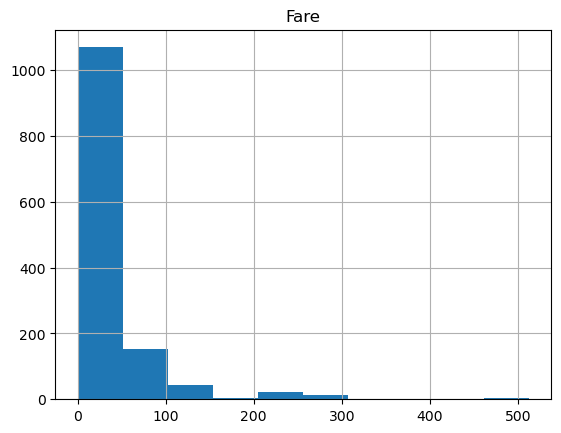

In [514]:
X_train[['Fare']].hist()

In [515]:
# before scaling numeric features, log them first
# only Fare's distribution is heavily long tailed

from sklearn.preprocessing import FunctionTransformer
log_cols = ['Fare']
X_train[log_cols] = X_train[log_cols] + 1 # plus one to avoid zero divided error
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(X_train[log_cols])
X_train[log_cols] = log_pop

In [516]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

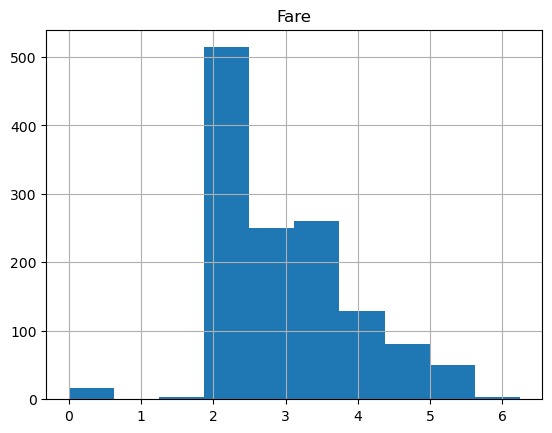

In [517]:
# Fare distribution after log
X_train[log_cols].hist()

In [518]:
X_train['Age'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1309 entries, 1 to 1309
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
1309 non-null   float64
dtypes: float64(1)
memory usage: 20.5 KB


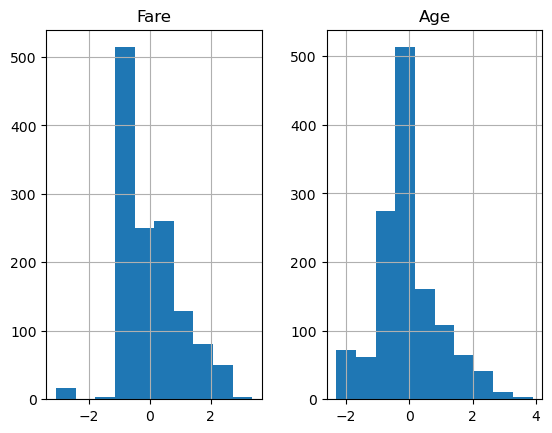

In [519]:
# Scale features

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_cols = ['Fare', 'Age']
std_fare = std_scaler.fit_transform(X_train[std_cols])
pd.DataFrame(std_fare, columns=std_cols).hist(bins=10)
X_train[std_cols] = pd.DataFrame(std_fare, columns=std_cols, index=X_train.index)

In [520]:
pd.DataFrame(std_fare, columns=std_cols).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fare    1308 non-null   float64
 1   Age     1309 non-null   float64
dtypes: float64(2)
memory usage: 20.6 KB


In [521]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pclass            1309 non-null   int64  
 1   Sex               1309 non-null   object 
 2   Age               1309 non-null   float64
 3   SibSp             1309 non-null   int64  
 4   Parch             1309 non-null   int64  
 5   Fare              1308 non-null   float64
 6   Embarked          1307 non-null   object 
 7   Name_transformed  1309 non-null   object 
 8   marriage_status   1309 non-null   object 
 9   Has_SibSp         1309 non-null   bool   
 10  Has_Parch         1309 non-null   bool   
dtypes: bool(2), float64(2), int64(3), object(4)
memory usage: 104.8+ KB


In [522]:
# one hot code for two categories columns
from sklearn.preprocessing import OneHotEncoder

col_encoder = ['Sex', 'Embarked', 'marriage_status','Has_SibSp', 'Has_Parch', 'Pclass']
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohe_data = ohe.fit_transform(X_train[col_encoder])

df_encoder = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(),
                          index=X_train.index)

X_train = X_train.join(df_encoder)
X_train.drop(col_encoder, axis=1, inplace=True)

In [525]:
X_train.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Name_transformed', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_nan',
       'marriage_status_ married', 'marriage_status_unknown',
       'Has_SibSp_False', 'Has_SibSp_True', 'Has_Parch_False',
       'Has_Parch_True', 'Pclass_1', 'Pclass_2', 'Pclass_3'],
      dtype='object')

In [529]:
X_train_model = X_train.loc[train_passengers,[ 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'Sex_female', 
                         'Sex_male']]
y_train_model = y_train[train_passengers]

In [532]:
y_train_model.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

In [562]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
forest_clf.fit(X_train_model, y_train_model)
X_pred = forest_clf.predict(X_train_model)
final_rmse = mean_squared_error(y_train_model, X_pred, squared=False)
final_rmse

ImportError: cannot import name 'cross_val_predict' from 'sklearn.metrics' (/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/__init__.py)

NameError: name 'recalls' is not defined

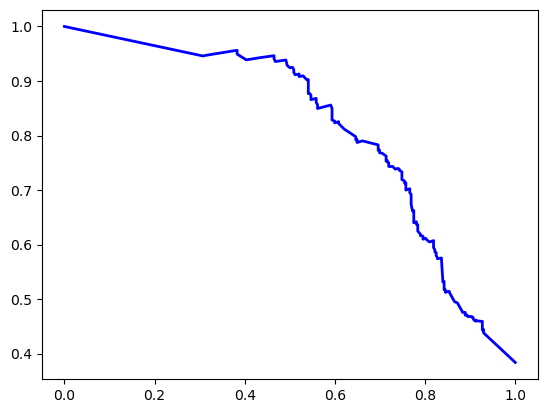

In [570]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score

y_probas_forest = cross_val_predict(forest_clf, X_train_model, y_train_model, cv=3, method='predict_proba', n_jobs=-1)
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_model, y_scores_forest)
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.ylabel("recalls")
plt.xlabel("precision")

In [595]:
y_train_pred_forest = y_probas_forest[:, 1] > 0.5

In [580]:
y_train_pred_forest

array([False,  True, False,  True, False, False, False, False,  True,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False, False, False,  True,  True, False, False, False,
       False, False, False, False,  True, False,  True,  True,  True,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False, False, False,  True, False,  True,  True,
       False, False,  True, False,  True, False, False,  True, False,
       False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False,

In [590]:
f1_score(y_train_model, y_train_pred_forest)

0.7140549273021003

In [591]:
max = {'f1_score': [], 'roc_auc_score': []}
f1_max, roc_auc_max = 0, 0
for i in range(0,10, 1):
    i = i/10
    y_train_pred_forest = y_probas_forest[:, 1] > i
    f1 = f1_score(y_train_model, y_train_pred_forest)
    if f1 > f1_max:
       max['f1_score'] = [f1, i] 
       f1_max = f1
    roc_auc = roc_auc_score(y_train_model, y_scores_forest)
    if roc_auc > roc_auc_max:
       max['roc_auc_score'] = [roc_auc, i] 
       roc_auc_max = roc_auc

In [596]:
max

{'f1_score': [0.7338345864661654, 0.5],
 'roc_auc_score': [0.8311070633475005, 0.0]}

In [597]:
roc_auc_score(y_train_model, y_scores_forest)

0.8311070633475005

In [642]:
from sklearn.model_selection import cross_val_score,cross_val_predict

tree_rmses = cross_val_score(forest_clf, X_train_model, y_train_model,
                              scoring="accuracy", cv=20, n_jobs=-1, )
tree_rmses

array([0.73333333, 0.8       , 0.8       , 0.84444444, 0.77777778,
       0.77777778, 0.75555556, 0.88888889, 0.91111111, 0.86666667,
       0.8       , 0.81818182, 0.72727273, 0.90909091, 0.81818182,
       0.79545455, 0.88636364, 0.79545455, 0.81818182, 0.79545455])

In [605]:
y_test_pred1 = forest_clf.predict(X_train.loc[test_passengers,[ 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'Sex_female', 
                         'Sex_male']])

In [627]:
output1 = pd.DataFrame(y_test_pred1.reshape(-1,1), columns=['Survived'], index=test_passengers)
output1 = output1.astype('int8')
output1.to_csv('gender_submission.csv')

In [628]:
output1

,Survived
PassengerId,
892,0
893,0
894,1
895,1
896,1
...,...
1305,0
1306,1
1307,0


## result
Linear Regaression has 0.76555 scores which is higher than Random Forest
* need to understand why?

In [598]:
from sklearn.linear_model import LinearRegression

linReg_clf = LinearRegression(n_jobs=-1)
linReg_clf.fit(X_train_model, y_train_model)
X_pred = linReg_clf.predict(X_train_model)
final_rmse = mean_squared_error(y_train_model, X_pred, squared=False)
final_rmse

0.3819076958274173

In [641]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(linReg_clf, X_train_model, y_train_model,
                              scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
tree_rmses.mean()

/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 106, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/liuyifu/miniconda3/envs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py", line 211, in accuracy_sco

nan

In [606]:
y_test_pred2 = linReg_clf.predict(X_train.loc[test_passengers,[ 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'Sex_female', 
                         'Sex_male']])

In [640]:
output2 = pd.DataFrame(y_test_pred2.reshape(-1,1), columns=['Survived'], index=test_passengers)
output2['Survived'] = output2['Survived'].round().astype('int')
output2.to_csv('gender_submission.csv')

In [638]:
output2.value_counts()

Survived
0           266
1           152
dtype: int64

In [639]:
output1.value_counts()

Survived
0           261
1           157
dtype: int64

In [616]:
output1.join(output2,lsuffix='_left', rsuffix='_right')

,Survived_left,Survived_right
PassengerId,,
892,0.0,0.059570
893,0.0,0.490234
894,1.0,0.107910
895,1.0,0.097656
896,1.0,0.616699
...,...,...
1305,0.0,0.083008
1306,1.0,0.892090
1307,0.0,0.039551


In [22]:
# from sklearn.base import BaseEstimator, TransformerMixin
# class columnDropperTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self,columns):
#         self.columns=columns

#     def transform(self,X,y=None):
#         return X.drop(self.columns,axis=1)

#     def fit(self, X, y=None):
#         return self 

In [23]:
# from sklearn.pipeline import Pipeline

# cleansing_pipeline = (
#     [
#     ("dropColumns", columnDropperTransformer(columns="Age")),
#     ("fill na", SimpleImputer(strategy="median"))
#     ]
# )